In [154]:
# EDA libraries
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import scipy.stats as stats
from IPython.display import HTML, display

# Features Selection
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.feature_selection import mutual_info_regression

# Modelling
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn import metrics, tree
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Lasso, Ridge

# EDA

In [2]:
df = pd.read_csv('bodyfat.csv')
df.head()

,Density,BodyFat,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
0,1.0708,12.3,23,154.25,67.75,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1
1,1.0853,6.1,22,173.25,72.25,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2
2,1.0414,25.3,22,154.00,66.25,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6
3,1.0751,10.4,26,184.75,72.25,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2
4,1.0340,28.7,24,184.25,71.25,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Density  252 non-null    float64
 1   BodyFat  252 non-null    float64
 2   Age      252 non-null    int64  
 3   Weight   252 non-null    float64
 4   Height   252 non-null    float64
 5   Neck     252 non-null    float64
 6   Chest    252 non-null    float64
 7   Abdomen  252 non-null    float64
 8   Hip      252 non-null    float64
 9   Thigh    252 non-null    float64
 10  Knee     252 non-null    float64
 11  Ankle    252 non-null    float64
 12  Biceps   252 non-null    float64
 13  Forearm  252 non-null    float64
 14  Wrist    252 non-null    float64
dtypes: float64(14), int64(1)
memory usage: 29.7 KB


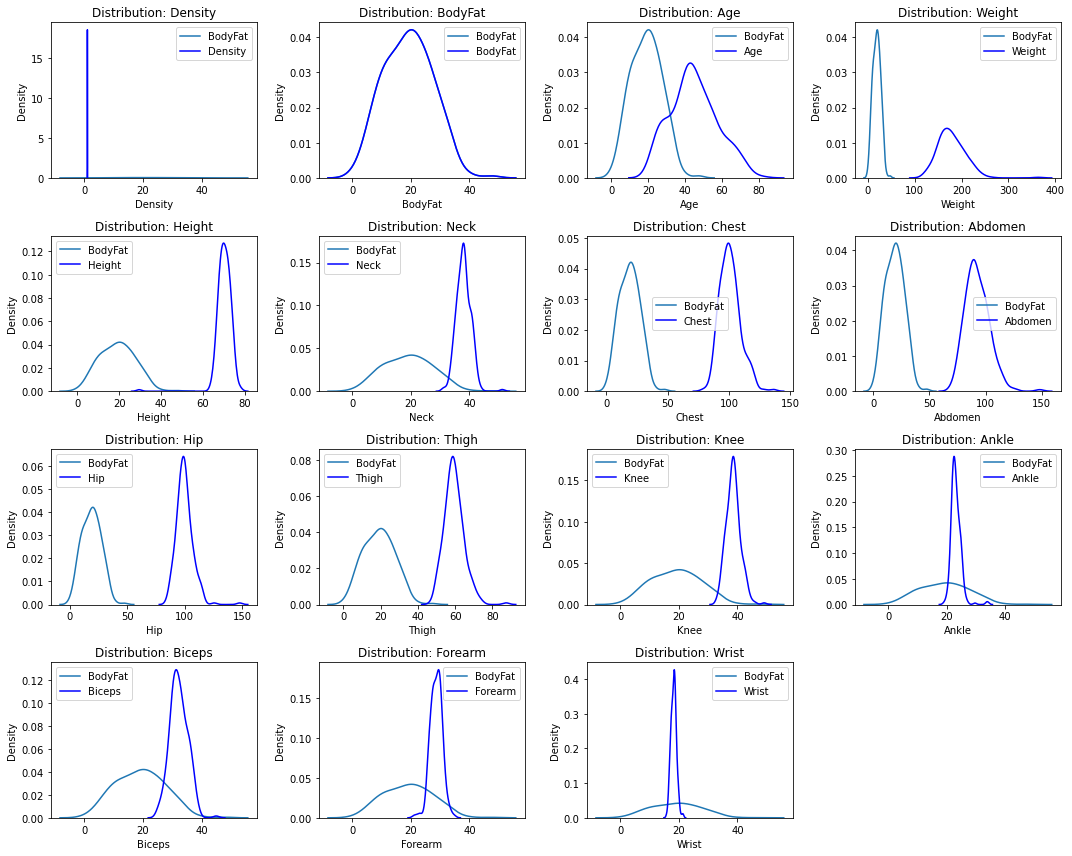

In [39]:
def plot_dist_plots(ax, col, target_col='BodyFat'):
    """
    Plot distribution of a variable compared to a target variable.
    
    Parameters:
    - ax (matplotlib.axes.Axes): The subplot where the plot will be created.
    - col (str): The column name for which to plot the distribution.
    - target_col (str): The target column name for comparison.
    """
    sn.distplot(df[target_col], hist=False, label=target_col, ax=ax)
    sn.distplot(df[col], color='blue', hist=False, label=col, ax=ax)
    ax.legend()

# Get a list of column names in the DataFrame
cols = list(df.columns)

# Calculate the number of rows and columns for the subplot grid
num_plots = len(cols)
num_rows = (num_plots + 3) // 4  # Round up to the nearest integer
num_cols = min(num_plots, 4)

# Create a figure and a grid of subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 12))  # Adjust the figure size as needed

# Iterate through each column and create distribution plots on corresponding subplots
for i, col in enumerate(cols):
    row_idx = i // num_cols
    col_idx = i % num_cols
    ax = axs[row_idx, col_idx]
    plot_dist_plots(ax, col)
    ax.set_title(f'Distribution: {col}')  # Set subplot title

# Hide any remaining empty subplots
for i in range(num_plots, num_rows * num_cols):
    axs.flatten()[i].axis('off')

# Adjust spacing between subplots and display
plt.tight_layout()
plt.show()

Distribution plots for Density


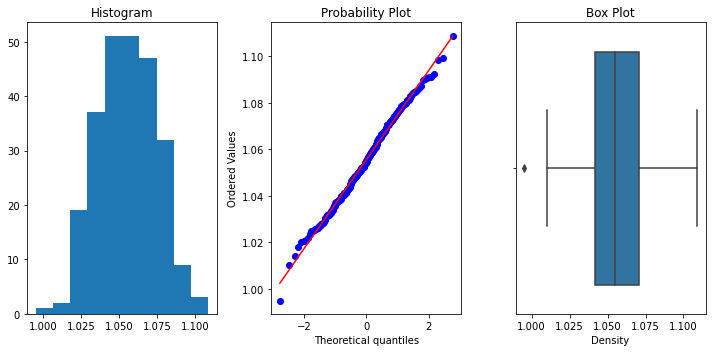

Distribution plots for BodyFat


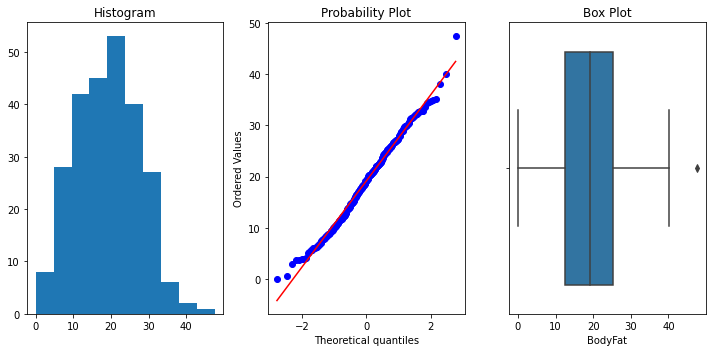

Distribution plots for Age


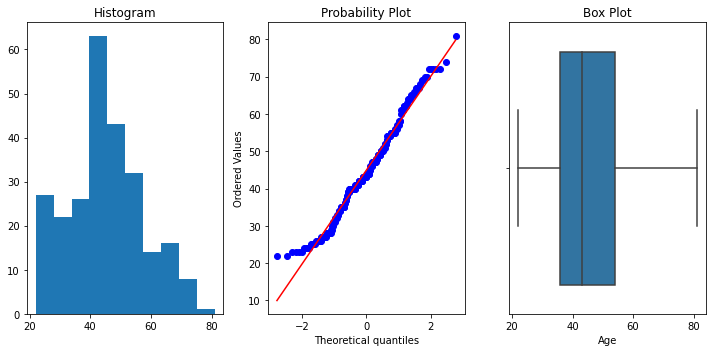

Distribution plots for Weight


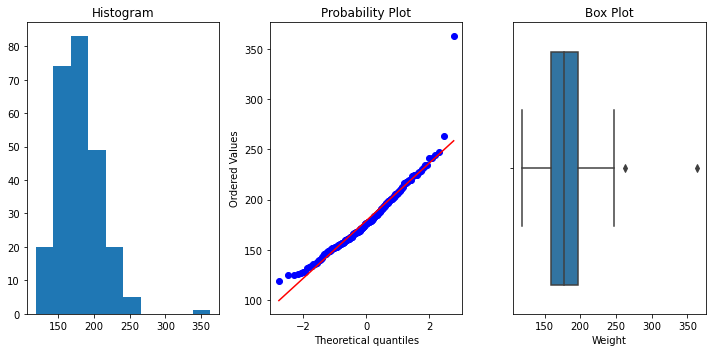

Distribution plots for Height


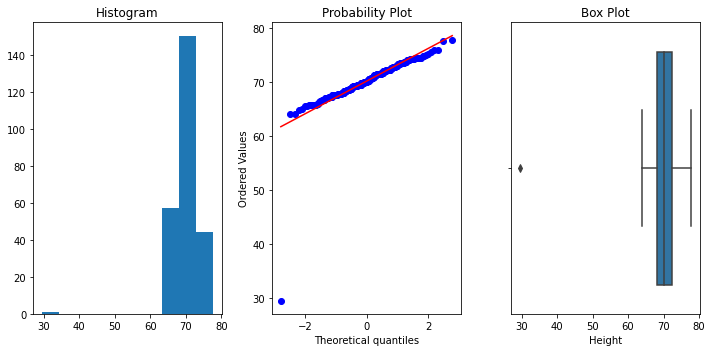

Distribution plots for Neck


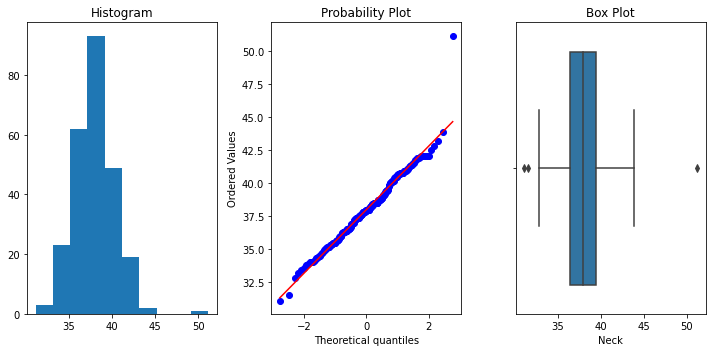

Distribution plots for Chest


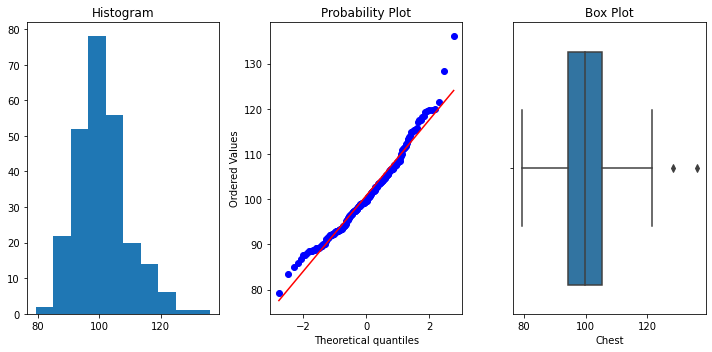

Distribution plots for Abdomen


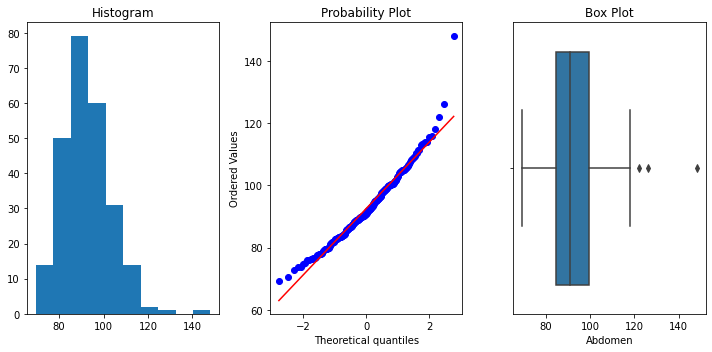

Distribution plots for Hip


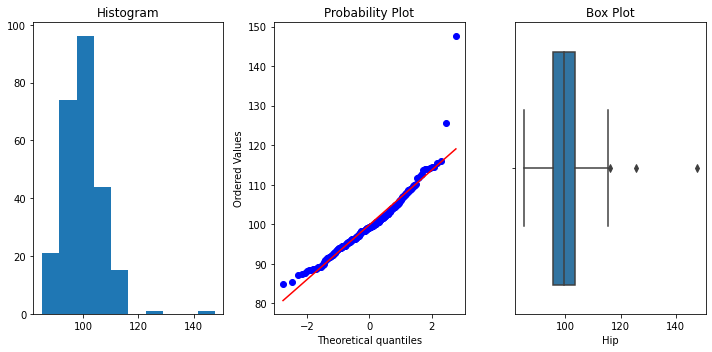

Distribution plots for Thigh


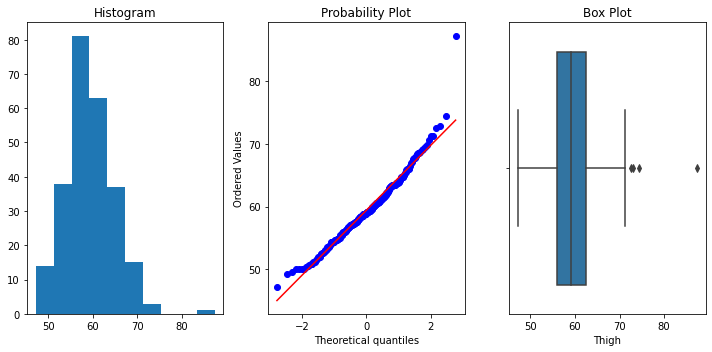

Distribution plots for Knee


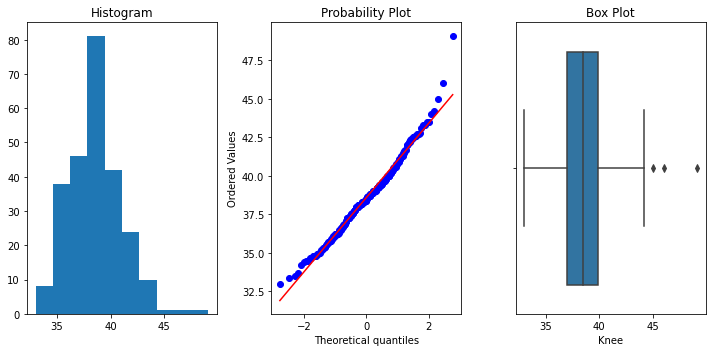

Distribution plots for Ankle


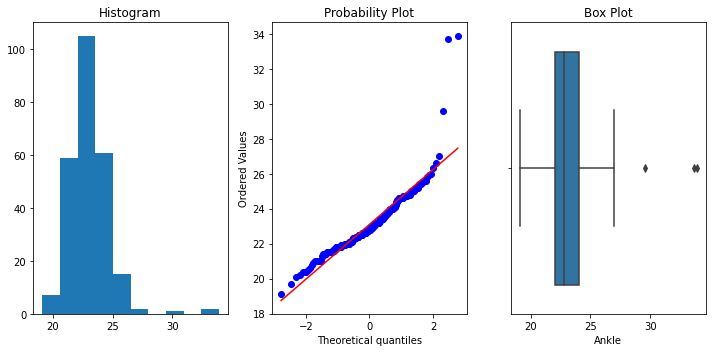

Distribution plots for Biceps


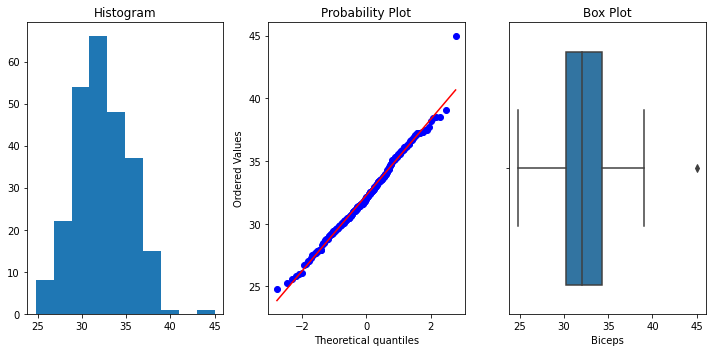

Distribution plots for Forearm


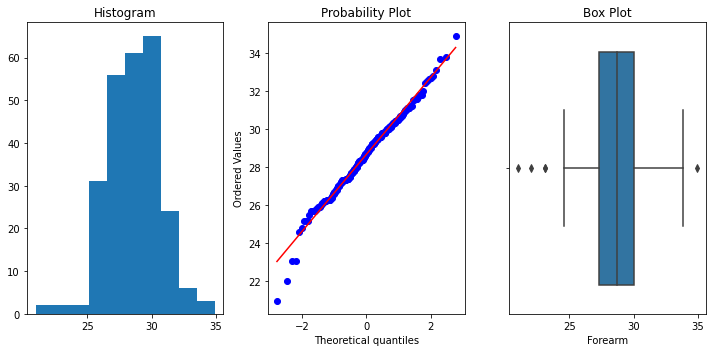

Distribution plots for Wrist


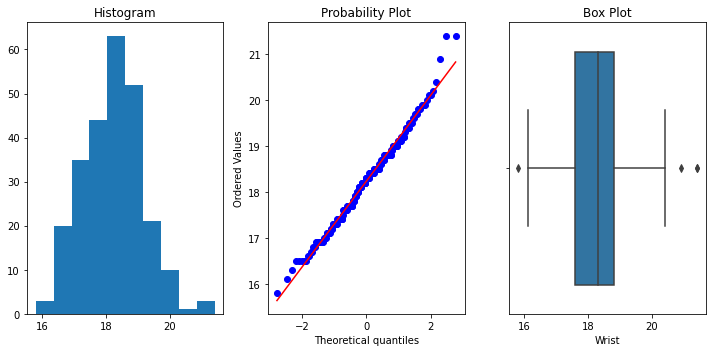

In [50]:
def draw_plots(df, col):
    """
    Draw distribution plots for a given column in the DataFrame.
    
    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data.
    - col (str): The column name for which to draw the distribution plots.
    """
    
    # Create a figure with three subplots
    plt.figure(figsize=(10, 5))
    
    # Subplot 1: Histogram
    plt.subplot(1, 3, 1)
    plt.hist(df[col])
    plt.title('Histogram')
    
    # Subplot 2: Probability Plot
    plt.subplot(1, 3, 2)
    stats.probplot(df[col], dist='norm', plot=plt)
    plt.title('Probability Plot')
    
    # Subplot 3: Box Plot
    plt.subplot(1, 3, 3)
    sn.boxplot(df[col])
    plt.title('Box Plot')
    
    # Display the plots
    plt.tight_layout()
    plt.show()

# Get a list of column names in the DataFrame
cols = list(df.columns)

# Iterate through each column and draw distribution plots
for i in range(len(cols)):
    print(f'Distribution plots for {cols[i]}')
    draw_plots(df, cols[i])

In [43]:
upperlimit = []
lowerlimit = []
for i in df.columns:
    upperlimit.append(df[i].mean()+(df[i].std())*4)
    lowerlimit.append(df[i].mean()-(df[i].std())*4)

In [46]:
j=0
for i in range(len(cols)):
    temp=df.loc[(df[cols[i]]>upperlimit[j])&(df[cols[i]]<lowerlimit[j])]
    j+=1

In [55]:
temp

,Density,BodyFat,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist


# Feature Selection

### ExtraTrees Regressor for Feature Selection

In [48]:
data = df.copy()
test = data['BodyFat']
train = data.drop(['BodyFat'], axis=1)

In [53]:
er = ExtraTreesRegressor()
er.fit(train, test)

ExtraTreesRegressor()

<AxesSubplot:>

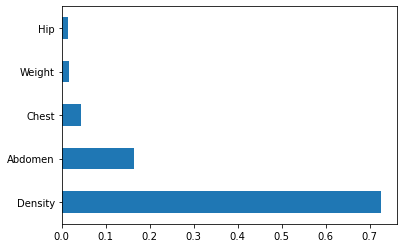

In [61]:
serieser = pd.Series(er.feature_importances_, index=train.columns)
serieser.nlargest(5).plot(kind='barh')

### Mutual Information Gain for Feature Selection

<AxesSubplot:>

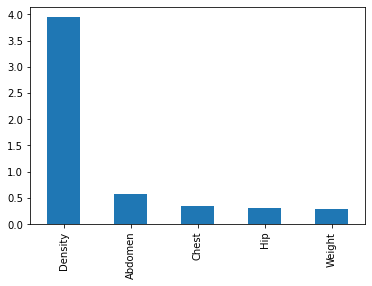

In [62]:
mr = mutual_info_regression(train, test)
plotmr = pd.Series(mr, index=train.columns)
plotmr.nlargest(5).plot(kind='bar')

### Removing correlation

<AxesSubplot:>

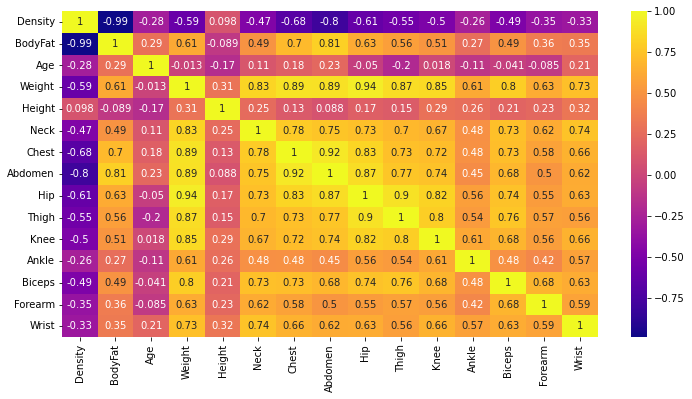

In [63]:
plt.figure(figsize=(12,6))
sn.heatmap(df.corr(), annot=True, cmap='plasma')

In [128]:
def find_highly_correlated_columns(df, threshold):
    """
    Find columns in the DataFrame that are highly correlated with each other.
    
    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data.
    - threshold (float): The correlation threshold value.
    
    Returns:
    - colcor (set): A set of column names that are highly correlated.
    """
    colcor = set()  # Initialize a set to store correlated column names
    cormat = df.corr()  # Calculate the correlation matrix
    
    # Iterate through the upper triangle of the correlation matrix
    for i in range(len(cormat)):
        for j in range(len(cormat)-1):
            # Check if the absolute correlation value exceeds the threshold
            if abs(cormat.iloc[i][j]) > threshold:
                colname = cormat.columns[i]
                colcor.add(colname)  # Add the column name to the set
    
    return colcor

# Modelling

In [143]:
totrain = train[plotmr.nlargest(5).index]
X_train, X_test, y_train, y_test = train_test_split(totrain, test, test_size=0.25)
X_train.shape, X_test.shape

((189, 5), (63, 5))

### Decision Tree Regressor

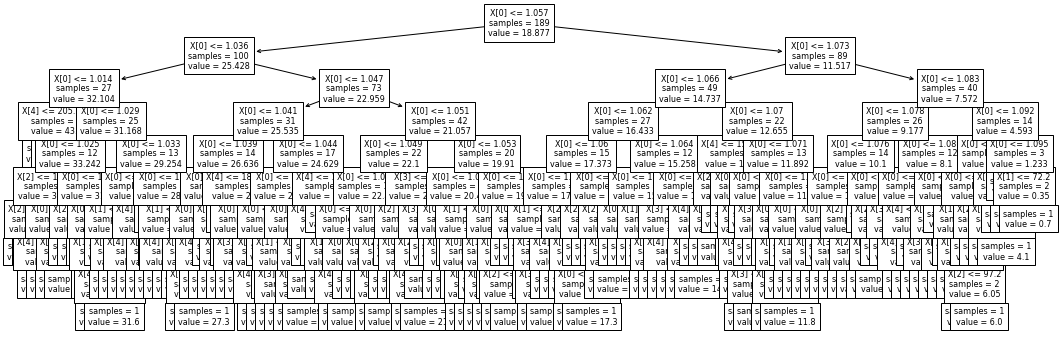

In [144]:
reg = DecisionTreeRegressor()
reg.fit(X_train, y_train)
plt.figure(figsize=(18, 6))
plot_tree(reg, impurity=False, filled=False, fontsize=8)
plt.show()

In [145]:
path = reg.cost_complexity_pruning_path(X_train, y_train)
ccp_alpha = path.ccp_alphas

In [146]:
alphalist = []
for i in range(len(ccp_alpha)):
    reg = DecisionTreeRegressor(ccp_alpha=ccp_alpha[i])
    reg.fit(X_train, y_train)
    alphalist.append(reg)

In [147]:
trainscore = [alphalist[i].score(X_train, y_train) for i in range(len(alphalist))]
testscore = [alphalist[i].score(X_test, y_test) for i in range(len(alphalist))]

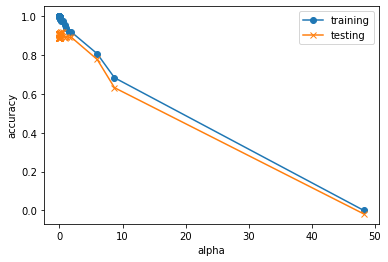

In [148]:
plt.xlabel('alpha')
plt.ylabel('accuracy')
plt.plot(ccp_alpha, trainscore, marker='o', label='training')
plt.plot(ccp_alpha, testscore, marker='x', label='testing')
plt.legend()
plt.show()

In [149]:
clf = DecisionTreeRegressor(ccp_alpha=1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(f'Decision Tree: {metrics.r2_score(y_test, y_pred)}')

Decision Tree: 0.8899845472517964


In [150]:
rf = RandomForestRegressor(n_estimators=1000, ccp_alpha=1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print(f'Random Forest: {metrics.r2_score(y_test, y_pred)}')

Random Forest: 0.8899845472517964


### Hyperparameter tuning

In [152]:
params = {
    'RandomForest':{
        'model': RandomForestRegressor(),
        'params': {
            'n_estimators': [int(x) for x in np.linspace(start=1, stop=1000, num=10)],
            'criterion': ['mse', 'mae'],
            'max_depth': [int(x) for x in np.linspace(start=1, stop=30, num=5)],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [2, 5, 10],
            'ccp_alpha': [int(x) for x in np.linspace(start=1, stop=5, num=10)],
        }
        
    },
    
    'D_tree': {
        'model': DecisionTreeRegressor(),
        'params':{
            'criterion': ['mse', 'mae'],
            'splitter': ['best', 'random'],
             'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [2, 5, 10],
            'ccp_alpha': [int(x) for x in np.linspace(start=1, stop=5, num=10)],           
        }
    },
    
    'SVM': {
        'model': SVR(),
        'params':{
            'C': [0.25, 0.5, 0.75, 1],
            'tol': [1e-10, 1e-5, 1e-4, 0.025, 0.5, 0.75],
            'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
        }
    }
}

In [156]:
scores = []
for modelname, mp in params.items():
    clf = RandomizedSearchCV(mp['model'], param_distributions=mp['params'],
                             cv=5, n_jobs=-1, n_iter=20, scoring='neg_mean_squared_error')
    
    clf.fit(X_train, y_train)
    scores.append({
        'model_name': modelname,
        'best_score': clf.best_score_,
        'best_estimator': clf.best_estimator_
    })

In [160]:
scoresdf = pd.DataFrame(scores, columns=['model_name', 'best_score', 'best_estimator'])
scoresdf 

,model_name,best_score,best_estimator
0,RandomForest,-5.292965,"(DecisionTreeRegressor(ccp_alpha=2, max_depth=..."
1,D_tree,-8.462592,"DecisionTreeRegressor(ccp_alpha=2, criterion='..."
2,SVM,-21.221607,"SVR(C=1, kernel='linear', tol=0.5)"


In [162]:
totrainlist = np.array(totrain)
predicted = []
for i in range(len(totrainlist)):
    predicted.append(rf.predict([totrainlist[i]]))

In [163]:
totrain['Actual Result'] = test
totrain['Predicted Result'] = np.array(predicted)
totrain

,Density,Abdomen,Chest,Hip,Weight,Actual Result,Predicted Result
0,1.0708,85.2,93.1,94.5,154.25,12.3,13.565041
1,1.0853,83.0,93.6,98.7,173.25,6.1,6.781301
2,1.0414,87.9,95.8,99.2,154.00,25.3,25.019402
3,1.0751,86.4,101.8,101.2,184.75,10.4,9.381900
4,1.0340,100.0,97.3,101.9,184.25,28.7,29.633312
...,...,...,...,...,...,...,...
247,1.0736,83.6,89.2,88.8,134.25,11.0,10.470932
248,1.0236,105.0,108.5,104.5,201.00,33.6,32.201193
249,1.0328,111.5,111.1,101.7,186.75,29.3,30.029389
250,1.0399,101.3,108.3,97.8,190.75,26.0,25.571220


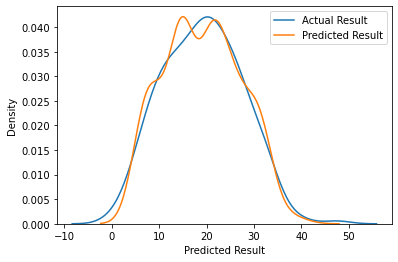

In [166]:
sn.distplot(totrain['Actual Result'], label='Actual Result', hist=False)
sn.distplot(totrain['Predicted Result'], label='Predicted Result', hist=False)
plt.legend()
plt.show()

In [167]:
import pickle
file = open('bodyfatmodel1.pkl', 'wb')
pickle.dump(rf, file)
file.close()